In [11]:
%matplotlib inline
import sys
sys.path.append("/home/simon/Documents/EPFL/Master/SemesterProject/MIP-DeepStroke/Unet") 
from Unet import image_processing
from Unet import predict
import os
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
def plot_patient(path, patient, layer, return_image_and_labels = False):
    path = os.path.join(path,str(patient),"t01")
    nii_file = nb.load(os.path.join(path,'output.nii'))
    img = nii_file.get_data()
    
    lesion_file = str(patient)+"_LesionSmooth_stx.nii"
    nii_file = nb.load(os.path.join(path,lesion_file))
    lesion = nii_file.get_data()
    
    fig = plt.figure(figsize=[15,5])
    plt.subplot(121)
    plt.imshow(img[:,:,layer])
    plt.subplot(122)
    plt.imshow(lesion[:,:,layer])
    fig.suptitle("Patient "+patient+" [{}]".format(layer),fontsize=20)
    plt.show()
    
    if return_image_and_labels:
        return img,lesion

siteA=5
pathA = "/home/simon/Datasets/Stroke_DeepLearning_ATLASdataset/Site"+str(siteA)+"/"
siteB=9
pathB = "/home/simon/Datasets/Stroke_DeepLearning_ATLASdataset/Site"+str(siteB)+"/"
layer = 110

#image_a, lesion_a = plot_patient(pathA,"031898",layer, return_image_and_labels=True)
image, lesion = plot_patient(pathB,"031974",layer, return_image_and_labels=True)

In [3]:
numpy_image = image_a
patch_size = (64,64,64)
mode = 'extend'

shape = numpy_image.shape
missing = np.array([patch_size[i]-(shape[i]%patch_size[i]) for i in range(len(patch_size))])
numpy_image_padded = np.zeros(numpy_image.shape+missing)

print(shape)
print(missing)


if mode is "extend":
    numpy_image_padded[:, :, :] = np.pad(numpy_image[:, :, :], [(0, missing[0]), (0, missing[1]), (0, missing[2])],
                                         mode="constant", constant_values=0)

NameError: name 'image_a' is not defined

In [ ]:
fig = plt.figure(figsize=[15,5])
plt.imshow(numpy_image_padded[:,:,layer])

In [ ]:
pos_indices = np.array(np.where(lesion_a>=1)).T
len(pos_indices)

In [ ]:
def get_lesion_ratio(patches_list):
    """Compute the ratio of lesioned tissue in total list of patches"""
    ratio = 0
    for p in patches_list:
        size = p.size
        ones = np.count_nonzero(p)
        r = float(ones)/float(size)
        ratio = ratio+r

    return float(ratio)/float(len(patches_list))

def get_lesion_center_ratio(patches_list):
    """Compute the ratio of lesioned tissue in total list of patches"""
    ratio = 0
    for p in patches_list:
        s = np.array(p.shape)/2
        s = s.astype(np.int64)
        center = p[s[0],s[1],s[2]]
        if(center>0):
            ratio+=1

    return float(ratio)/float(len(patches_list))

In [ ]:
patch_size = [32,32,32]
patch_labels = image_processing.create_patches_from_images(lesion_a,patch_size)
print(len(patch_labels))

In [ ]:
print(get_lesion_ratio(patch_labels))
print(get_lesion_center_ratio(patch_labels))

In [ ]:
def check_bounds(center_x, center_y, center_z, image, patch_size):
    x_begin = center_x - int(patch_size[0] / 2.0)
    x_end = center_x + int(patch_size[0] / 2.0)
    y_begin = center_y - int(patch_size[1] / 2.0)
    y_end = center_y + int(patch_size[1] / 2.0)
    z_begin = center_z - int(patch_size[2] / 2.0)
    z_end = center_z + int(patch_size[2] / 2.0)
    
    inside = x_begin>=0 and y_begin>=0 and z_begin>=0
    not_outside = x_end<=image.shape[0] and y_end<=image.shape[1] and z_end<=image.shape[2]
    return inside and not_outside

In [ ]:
patch_size = (128,128,128)

image_padded = np.pad(image, [(int(patch_size[0]/2), int(patch_size[0]/2)), 
                       (int(patch_size[1]/2), int(patch_size[1]/2)), 
                       (int(patch_size[2]/2), int(patch_size[2]/2))], 
                        mode="constant", constant_values=0)

lesion_padded = np.pad(lesion, [(int(patch_size[0]/2), int(patch_size[0]/2)), 
                       (int(patch_size[1]/2), int(patch_size[1]/2)), 
                       (int(patch_size[2]/2), int(patch_size[2]/2))], 
                        mode="constant", constant_values=0)

pos_indices = np.array(np.where(lesion_padded>=1)).T  

patches_image = []
patches_lesion = []

random_indices = np.arange(len(pos_indices))
np.random.shuffle(random_indices)
sampled_indices = [pos_indices[x] for x in random_indices]

for x,y,z in sampled_indices:
    if check_bounds(x,y,z,image_padded,patch_size):
        patch_image = image_processing.create_patch_around(x,y,z,patch_size, image_padded)
        patch_lesion = image_processing.create_patch_around(x,y,z,patch_size, lesion_padded)
        
        patches_image.append(patch_image)
        patches_lesion.append(patch_lesion)
        
        #TODO remove
        layer = int(patch_size[2]/2)
        plt.subplot(121)
        plt.imshow(patch_image[:,:,layer])
        plt.subplot(122)
        plt.imshow(patch_lesion[:,:,layer])
        plt.show()


In [12]:
def get_patient(patient, path):
    input_path = os.path.join(path,"input")
    mask_path = os.path.join(path,"mask")
    inputs = [x for x in os.listdir(input_path) if patient in x and "extra" not in x]

    patches = []
    patches_lesion = []
    for i in range(336):
        filepath = os.path.join(input_path,"input_{}-{}.nii".format(patient,i))
        filepath2 = os.path.join(mask_path,"mask_{}-{}.nii".format(patient,i))
        patch = nb.load(filepath).get_data()
        lesionp = nb.load(filepath2).get_data()
        patches.append(patch)
        patches_lesion.append(lesionp)

    original_image_size = (197, 233, 189)
    brain = image_processing.recreate_image_from_patches(original_image_size,list_patches=patches)
    lesion = image_processing.recreate_image_from_patches(original_image_size,patches_lesion)
    return brain, lesion

In [14]:
path_data = "/home/simon/Datasets/Data/32x32x32/validation"
mask_path = os.path.join(path_data,"mask")
input_path =  os.path.join(path_data,"input")

patient = "031836"
brain, lesion = get_patient(patient, path_data)

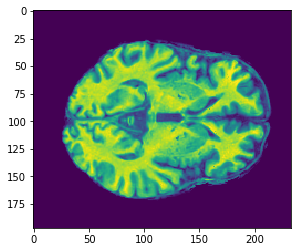

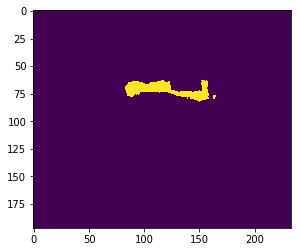

In [30]:
plt.imshow(brain[:,:,70])
plt.show()
plt.imshow(lesion[:,:,100])
plt.show()

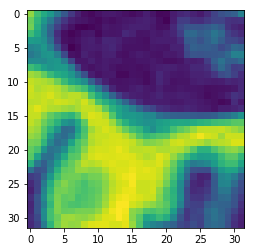

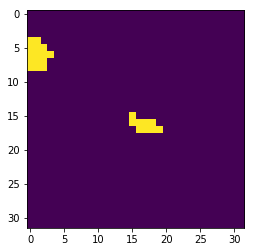

In [7]:
i=3
patches=[]
patches_lesion=[]
filepath = os.path.join(input_path,"input_{}-{}-extra.nii".format(patient,i))
filepath2 = os.path.join(mask_path,"mask_{}-{}-extra.nii".format(patient,i))
patch = nb.load(filepath).get_data()
lesionp = nb.load(filepath2).get_data()
patches.append(patch)
patches_lesion.append(lesionp)

    
plt.imshow(patch[:,:,16])
plt.show()
plt.imshow(lesionp[:,:,16])
plt.show()

In [ ]:
def normalize_numpy(v):
    return v/v.max()

print(lesionp.max())
lesionp_norm = normalize_numpy(lesionp)
print(lesionp_norm.max())
plt.imshow(lesionp_norm[:,:,16])
plt.show()
plt.imshow(normalize_numpy(patch)[:,:,16])
plt.show()

In [8]:
model_path = "/home/simon/model.25--0.14.hdf5"
model = predict.load_old_model(model_path)

Loading pre-trained model


In [12]:
from tqdm import tqdm
patch_size = [32,32,32]
path_data = "/home/simon/Datasets/Data/32x32x32/train"
brain, lesion = get_patient("031930",path_data)


patches_brain = image_processing.create_patches_from_images(brain,patch_size)
patches_lesion = image_processing.create_patches_from_images(lesion, patch_size)
predictions=[]
for p in tqdm(patches_brain):
    p = p.reshape(1,1,32,32,32)
    #pred = model.predict(p)[0][0]
    pred=np.array([0,0])
    predictions.append(pred)

original_image_size = [197, 233, 189]
lesion_pred = image_processing.recreate_image_from_patches(original_image_size, predictions)
plt.imshow(lesion_pred)
plt.show()

100%|██████████| 336/336 [00:00<00:00, 362470.72it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

4/4 [==============================] - 13s 3s/step
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(4, 1, 32, 32, 32)


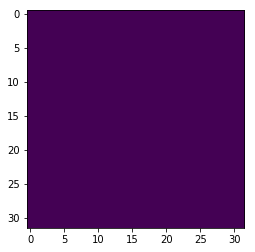

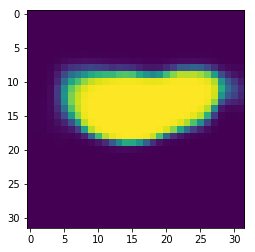

In [20]:
import numpy as np
array = patches_brain[0]
a = [p.reshape(1,32,32,32) for p in patches_brain[:4]]

predictions = model.predict(np.asarray(a), verbose=1, batch_size=2)
for p in predictions:
    print(p.shape)
print(predictions.shape)
plt.imshow(patches_brain[3][:,:,16])
plt.show()
plt.imshow(predictions[3,0,:,:,16])
plt.show()

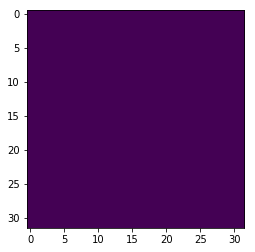

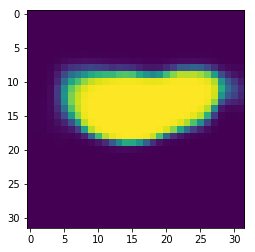

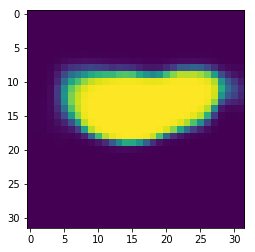

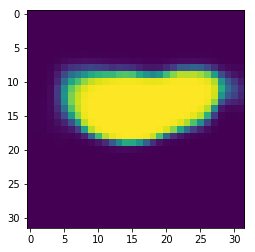

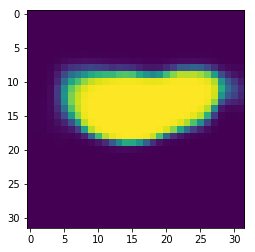

In [34]:
a = predictions[:,0,:,:,:]
tot = a[1]-a[3]
plt.imshow(tot[:,:,16])
plt.show()
for p in a:
    tot
    plt.imshow(p[:,:,16])
    plt.show()

In [ ]:
p = patch
plt.imshow(p[:,:,16])
plt.show()
p = p.reshape(1,1,32,32,32)
pred = model.predict(p)
#prediction.append(pred)
#lesion_pred = image_processing.recreate_image_from_patches(original_image_size, prediction)
plt.imshow(pred[0,0,:,:,16])
plt.show()

## Validation

In [ ]:
validation_path = "/home/simon/Datasets/Data/32x32x32/validation"
patient="031823"

input_path = os.path.join(validation_path, "input")
input_path = os.path.join(validation_path, "mask")


b, l = get_patient(patient,validation_path)
plt.imshow(b[:,:,70])
plt.show()
plt.imshow(l[:,:,70])
plt.show()

In [ ]:
l.max()